In [170]:
import torch
import torch.nn as nn
from torch.autograd import Function, Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from qpth.qp import QPFunction

import pandas as pd
import numpy as np
from matplotlib import ticker
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [171]:
np.random.seed(0)
torch.manual_seed(0)

In [172]:
# plotting parameters
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)
plt.rc('legend', fontsize=10)

width = 5
height = width/1.618

## Differentiable Elastic-net regression

The function `batch_solve` performs batched elastic-net regression. Given a K x N x n tensor of `Xs` data and K x N tensor `ys` of targets, the function converts the data into the matrices for the QP solved by elastic-net regression and returns the learned coefficient vectors and intercepts.

In [173]:
def batch_solve(Xs, ys, lamb):
    batch_size, N, n = Xs.size()

    # since elastic-net does not penalize intercepts, find intercepts
    intercepts = Variable(torch.zeros(batch_size, 1))
    for i in range(batch_size):
        lr = LinearRegression()
        lr.fit(Xs[i].data.numpy(), ys[i].data.numpy())
        intercepts[i] = torch.FloatTensor([lr.intercept_[0]]).unsqueeze(-1)
    
    # form tensors X^T X and X^T (y-intercepts)
    XtX = torch.bmm(Xs.transpose(1,2), Xs)
    Xty = torch.bmm(Xs.transpose(1,2), (ys.squeeze(-1) - intercepts).unsqueeze(-1))
    
    # useful tensors
    eye = Variable(torch.eye(n).repeat([batch_size, 1, 1]))
    ones = Variable(torch.ones(n,1).repeat([batch_size, 1, 1]))
    
    # form QP parameters
    Q = torch.cat([
        torch.cat([1./N*XtX+lamb[1]*eye, -1./N*XtX],1),
        torch.cat([-1./N*XtX, 1./N*XtX+lamb[1]*eye],1)
    ],2)
    p = torch.cat([-1./N*Xty+lamb[0]*ones, 1./N*Xty+lamb[0]*ones],1).squeeze()
    G = Variable(-torch.eye(2*n).repeat([batch_size, 1, 1]))
    h = Variable(torch.zeros(batch_size, 2*n))
    e = Variable(torch.Tensor())
    
    # batch solve QP
    z = QPFunction(verbose=-1)(Q,p,G,h,e,e)
    
    # return coefficient vector and intercepts
    return z[:,:n] - z[:,n:], intercepts

## Make dataset

Next, we construct artificial regression data with $N=1000$ and $n=10$, but only $8$ of the features are informative.

In [176]:
N = 1000
n = 10
X, y, coef = make_regression(N, n, n_informative=8, noise=100., \
                             tail_strength=0., coef=True)
y /= 100.
coef /= 100.
print ("coefficients", coef)
print ("E[y]", np.mean(y))
print ("std[y]", np.std(y))

coefficients [0.98982973 0.08412531 0.23580962 0.63365848 0.37441971 0.5469327
 0.92164717 0.         0.29819623 0.        ]
E[y] 0.005752656861007601
std[y] 1.8610587417372477


Next, we select only 30 of the points to be training points and convert them to pytorch variables.

In [177]:
N, n = X.shape

ntrain = 30
ntest = N-ntrain
print ("ntrain:", ntrain)
print ("ntest:", ntest)

X_train, y_train = X[:ntrain,:], y[:ntrain]
X_test, y_test = X[ntrain:,:], y[ntrain:]

X_train = Variable(torch.FloatTensor(X_train), requires_grad=False)
y_train = Variable(torch.FloatTensor(y_train), requires_grad=False).unsqueeze(-1)
X_test = Variable(torch.FloatTensor(X_test), requires_grad=False)
y_test = Variable(torch.FloatTensor(y_test), requires_grad=False).unsqueeze(-1)

ntrain: 30
ntest: 970


Next, we split the training data into $64$ random partitions with $27$ training points and $3$ validation points.

In [178]:
# split into K random partitions
K = 128
f = .95
Xs_train = torch.zeros(K, int(ntrain*f), n)
ys_train = torch.zeros(K, int(ntrain*f), 1)
Xs_val = torch.zeros(K, ntrain-int(ntrain*f), n)
ys_val = torch.zeros(K, ntrain-int(ntrain*f), 1)

for i in range(K):
    indices = np.random.permutation(ntrain)
    training_idx, val_idx = indices[:int(ntrain*f)], indices[int(ntrain*f):]
    training_idx = torch.LongTensor(training_idx)
    val_idx = torch.LongTensor(val_idx)
    # fit scaling to training data, but apply to all data.
    scaler = preprocessing.StandardScaler().fit(X_train[training_idx].data.numpy())
    X_train1 = Variable(torch.Tensor(scaler.transform(X_train.data.numpy())))
    Xs_train[i] = X_train1[training_idx]; ys_train[i] = y_train[training_idx]
    Xs_val[i] = X_train1[val_idx]; ys_val[i] = y_train[val_idx]

scaler = preprocessing.StandardScaler().fit(X_train.data.numpy())
X_train1 = Variable(torch.Tensor(scaler.transform(X_train.data.numpy())))
X_test1 = Variable(torch.Tensor(scaler.transform(X_test.data.numpy())))

### Standard Linear Regression

In [179]:
lr = LinearRegression()
lr.fit(X_train.data.numpy(), y_train.data.numpy())
lr_loss = np.linalg.norm(lr.predict(X_test.data.numpy()) - y_test.data.numpy())**2 / y_test.shape[0]
lr_loss

1.2847221015464214

### Loss achieved by true coefficients

In [180]:
best_loss = np.linalg.norm(np.dot(X_test.data.numpy(), coef) - y_test.data.numpy().flatten())**2 / y_test.size()[0]
best_loss

0.960613829513703

### CVGM

In [191]:
lamb = Variable(torch.FloatTensor([1e-2,1e-4]), requires_grad=True)
optimizer = torch.optim.SGD([lamb], lr=2e-4)

In [192]:
val_losses, test_losses = [], []
for k in range(1,100):
    zs, intercepts = batch_solve(X_train1.repeat([1,1,1]), y_train.repeat([1,1,1]), lamb.detach())
    Xz_minus_y = torch.mm(X_test1, zs.squeeze(0).unsqueeze(-1)) + intercepts - y_test
    test_loss = torch.norm(Xz_minus_y)**2 / (X_test.size()[0])
    z_test = zs.squeeze()
    
    def step():
        optimizer.zero_grad()
        zs, intercepts = batch_solve(Xs_train, ys_train, lamb)
        Xz_minus_y = torch.bmm(Xs_val, zs.unsqueeze(-1)).squeeze() + intercepts - ys_val.squeeze()
        loss = torch.norm(Xz_minus_y)**2 / (K * Xs_val.size()[1])
        loss.backward()
        return loss
    optimizer.step(step)
    if lamb[1].data.item() < 1e-7:
        lamb.data[1] = torch.FloatTensor([1e-7])
    if lamb[0].data.item() <= 0:
        lamb.data[0] = torch.FloatTensor([1e-8])

    print (torch.norm(lamb.grad.data).item())
    print ("test loss: %.3f | lamb_1: %.5f | lamb_2 %.5f" \
           % (test_loss.item(), lamb[0].data.item(), lamb[1].data.item()))
    test_losses.append(test_loss.item())

5.611355304718018
test loss: 1.222 | lamb_1: 0.01085 | lamb_2 0.00083
5.558211326599121
test loss: 1.216 | lamb_1: 0.01170 | lamb_2 0.00155
5.390768051147461
test loss: 1.209 | lamb_1: 0.01253 | lamb_2 0.00224
5.199543476104736
test loss: 1.203 | lamb_1: 0.01332 | lamb_2 0.00291
5.038514137268066
test loss: 1.198 | lamb_1: 0.01408 | lamb_2 0.00357
4.863897800445557
test loss: 1.192 | lamb_1: 0.01481 | lamb_2 0.00422
4.927940368652344
test loss: 1.187 | lamb_1: 0.01557 | lamb_2 0.00485
4.998310089111328
test loss: 1.182 | lamb_1: 0.01634 | lamb_2 0.00548
4.671179294586182
test loss: 1.177 | lamb_1: 0.01703 | lamb_2 0.00611
4.652484893798828
test loss: 1.173 | lamb_1: 0.01773 | lamb_2 0.00673
4.54174280166626
test loss: 1.168 | lamb_1: 0.01840 | lamb_2 0.00734
4.808726787567139
test loss: 1.164 | lamb_1: 0.01914 | lamb_2 0.00795
4.699917793273926
test loss: 1.160 | lamb_1: 0.01986 | lamb_2 0.00856
4.765109062194824
test loss: 1.156 | lamb_1: 0.02060 | lamb_2 0.00916
4.6783294677734375
te

### Exhaustive Search

In [185]:
lambda_1s = np.logspace(-4,-1,10)
lambda_2s = np.logspace(-4,-1,10)

best_val_loss = float("inf")
best_test_loss = float("inf")
test_losses_es = []

for lambda_1 in lambda_1s:
    for lambda_2 in lambda_2s:
        lamb = Variable(torch.FloatTensor([lambda_1,lambda_2]), requires_grad=False)
        zs, intercepts = batch_solve(X_train1.repeat([1,1,1]), y_train.repeat([1,1,1]), lamb)
        Xz_minus_y = torch.mm(X_test1, zs.squeeze(0).unsqueeze(-1)) + intercepts - y_test
        test_loss = torch.norm(Xz_minus_y)**2 / (X_test.size()[0])
        z_test = zs.squeeze()

        zs, intercepts = batch_solve(Xs_train, ys_train, lamb)
        Xz_minus_y = torch.bmm(Xs_val, zs.unsqueeze(-1)).squeeze() + intercepts - ys_val.squeeze()
        loss = torch.norm(Xz_minus_y)**2 / (K * Xs_val.size()[1])

        if loss.item() < best_val_loss:
            best_val_loss = loss.item()
            best_test_loss = test_loss.item()
            print (best_test_loss)
        test_losses_es.append(best_test_loss)

1.2836827039718628
1.283287525177002
1.28243887424469
1.2806226015090942
1.2767685651779175
1.2687300443649292
1.2525817155838013
1.2226037979125977
1.1763238906860352
1.1325914859771729
1.1323691606521606
1.1318926811218262
1.1308776140213013
1.1287450790405273
1.1243939399719238
1.1161717176437378
1.1037893295288086
1.1059244871139526
1.13079833984375
1.1540684700012207
1.2074096202850342


### Random Search

In [186]:
best_val_loss = float("inf")
best_test_loss_rs = float("inf")
test_losses_rs = []
for _ in range(100):
    lamb = Variable(torch.FloatTensor([10**np.random.uniform(-4,-1),10**np.random.uniform(-4,-1)]), requires_grad=False)
    zs, intercepts = batch_solve(X_train1.repeat([1,1,1]), y_train.repeat([1,1,1]), lamb)
    Xz_minus_y = torch.mm(X_test1, zs.squeeze(0).unsqueeze(-1)) + intercepts - y_test
    test_loss = torch.norm(Xz_minus_y)**2 / (X_test.size()[0])
    z_test = zs.squeeze()

    zs, intercepts = batch_solve(Xs_train, ys_train, lamb)
    Xz_minus_y = torch.bmm(Xs_val, zs.unsqueeze(-1)).squeeze() + intercepts - ys_val.squeeze()
    loss = torch.norm(Xz_minus_y)**2 / (K * Xs_val.size()[1])

    if loss.item() < best_val_loss:
        best_val_loss = loss.item()
        best_test_loss = test_loss.item()
        print (best_test_loss)
    test_losses_rs.append(best_test_loss)

1.282341718673706
1.2604131698608398
1.13634192943573
1.1333262920379639
1.0839056968688965
1.083789587020874


### Plot and final results

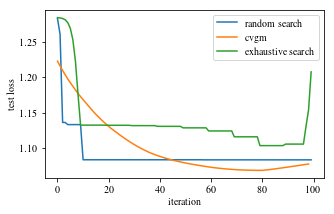

In [193]:
fig = plt.figure()
plt.plot(test_losses_rs[:100], label='random search')
plt.plot(test_losses, label='cvgm')
plt.plot(test_losses_es, label='exhaustive search')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('test loss')
fig.set_size_inches(width, height)
plt.savefig('figures/comparison.pdf')
plt.show()

In [188]:
print ("cvgm test:", test_losses[-1])
print ("rs test:", test_losses_rs[100])
print ("es test:", test_losses_es[-1])

cvgm test: 1.080196499824524


IndexError: list index out of range